In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import csv
import random
import copy

from pyimagesearch.siamese_network import build_siamese_model
from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda

### Paths

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/alvaro/siamese


It should be /home/user/siamese

### Dataset parameters

In [3]:
total_classes = 20
elements_per_class = 50
training_split = 0.75
img_resolution = (640, 640)

### Training parameters

### Load images

In [4]:
os.chdir(ROOT_DIR + '/dataset')

In [5]:
car_names = os.listdir('./')
car_names.sort()

In [6]:
labels = random.sample(car_names, k = total_classes)
labels.sort()
print(labels)

['Acura TL Sedan 2012', 'Audi 100 Wagon 1994', 'Audi TTS Coupe 2012', 'BMW X3 SUV 2012', 'Bugatti Veyron 16.4 Convertible 2009', 'Cadillac Escalade EXT Crew Cab 2007', 'Chevrolet Corvette Convertible 2012', 'Chevrolet Traverse SUV 2012', 'Chrysler Sebring Convertible 2010', 'Ferrari California Convertible 2012', 'Ford Expedition EL SUV 2009', 'Hyundai Sonata Hybrid Sedan 2012', 'Infiniti QX56 SUV 2011', 'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993', 'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz Sprinter Van 2012', 'Nissan Leaf Hatchback 2012', 'Ram CV Cargo Van Minivan 2012', 'smart fortwo Convertible 2012']


In [7]:
def load_dataset(labels, elements_per_class=15, training_split=0.75, img_resolution=(960,640)):
    os.chdir(os.path.join(ROOT_DIR, 'dataset'))
    trainX = []
    trainY = []
    testX = []
    testY = []
    trainX_bbox = []
    testX_bbox = []
    
    for each_dir in labels:
        os.chdir(each_dir)
        img_filenames = [file for file in os.listdir('./') if file.endswith('.jpg')]
        img_filenames = random.sample(img_filenames, elements_per_class)
        random.shuffle(img_filenames)
        n = len(img_filenames)
        split = round(training_split * n)
        train_img_filename = img_filenames[:split]
        test_img_filename = img_filenames[split:]
        
        for each_img in train_img_filename:
            img = cv2.imread(each_img)
            # OpenCV loads images to BGR by default (modify this to RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_resolution)
            trainX.append(img)
            
            csv_filename = each_img.split('.')[0] + '.csv'
            with open(csv_filename) as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    trainX_bbox.append([int(row[0]), int(row[1]), int(row[2]), int(row[3])])
                    trainY.append(int(row[4]))
            
        for each_img in test_img_filename:
            img = cv2.imread(each_img)
            # OpenCV loads images to BGR by default (modify this to RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_resolution)
            testX.append(img)
            
            csv_filename = each_img.split('.')[0] + '.csv'
            with open(csv_filename) as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    testX_bbox.append([int(row[0]), int(row[1]), int(row[2]), int(row[3])])
                    testY.append(int(row[4]))
        
        os.chdir('..')
        
    return (trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox)

In [8]:
(trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox) = utils.load_dataset(ROOT_DIR, labels, elements_per_class, img_resolution=img_resolution, crop=True)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)
trainX.shape

(760, 640, 640)

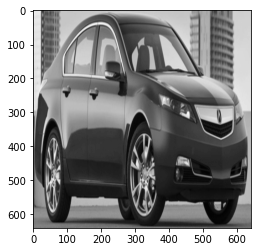

In [9]:
plt.imshow(trainX[0], cmap='gray')

In [10]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(760, 640, 640, 1)
(240, 640, 640, 1)


In [11]:
norm_trainY = utils.normalize_labels(trainY)
norm_testY = utils.normalize_labels(testY)

In [12]:
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = utils.make_pairs(trainX, norm_trainY)
(pairTest, labelTest) = utils.make_pairs(testX, norm_testY)

[INFO] preparing positive and negative pairs...


In [13]:
pairTrain.shape

(1520, 2, 640, 640, 1)

In [14]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=(img_resolution[0], img_resolution[1], 1))
imgB = Input(shape=(img_resolution[0], img_resolution[1], 1))
featureExtractor = build_siamese_model((img_resolution[0], img_resolution[1], 1))
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

[INFO] building siamese network...
[INFO] compiling model...


In [15]:
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=4, 
	epochs=config.EPOCHS)

[INFO] training model...
Epoch 1/100
 23/380 [>.............................] - ETA: 9:03 - loss: 5.9577 - accuracy: 0.4959

KeyboardInterrupt: 

In [16]:
config.BATCH_SIZE

64